In [1]:
import os

# Get current working directory
current_dir = os.getcwd()

print("Current directory:", current_dir)

Current directory: C:\Users\Mhdella\iHelm\Buro_Clustering


In [2]:
# scaling_sw=1  ## scaling data
scaling_sw=0  ## not scaling 

In [3]:
# shap_run=1 ## Run shap value
shap_run=0 ## Do not run shap values

In [4]:
# Branch=21;  br='br21'   ##Branching Direct and Non-direct
# Branch=52;  rt='br52'    ##Branching sub-paths, Non-Direct and Direct

Branch=62;  br='br62'   ##Branching Direct, West_Canal, and East_Canal

In [5]:
nth_mid_sth_fg=0 ## All sections
# nth_mid_sth_fg=1 ##North section
# nth_mid_sth_fg=2 ##Middle section
# nth_mid_sth_fg=3 ##South section
# nth_mid_sth_fg=4 ##Direct routes
# nth_mid_sth_fg=13 ##North and South sections
# nth_mid_sth_fg=134 ##North and South sections and direct routes
# nth_mid_sth_fg=5  ##  All sections except direct routes

In [6]:
# local_Eff_fg=1  ## use local data, where the eff-score calculated every timestep, 1min rather than the total route
local_Eff_fg=0

In [7]:
# gr_ock_fg=1  ## select Groto to Ockero routes only
# gr_ock_fg=0  ## select Ockero to Groto routes only
gr_ock_fg=2  ## ALl data together

In [8]:
####Data Partition
train_pt=0.70  ## partition data between training and test
test_pt=0.81   ## partition data between valid and test

# ####Data Partition
# train_pt=0.70  ## partition data between training and test
# # test_pt=0.81   ## partition data between valid and test
# test_pt=0.735

In [9]:
tempo_res='1min'  ; dw=0.005

###########
# import shap
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind

In [10]:
# Output_folder='Buro_cluster_v6_3_8'
Output_folder='Outputs_Buro_cluster_by_distance_v2'


In [11]:
# folder_path = r'C:/Users/'+user_name+'/OneDrive - Högskolan i Halmstad/iHelm/Buro_Clustering/Outputs/'+Eff_SOG_Subfolder


folder_path = r''+Output_folder
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [12]:
df = pd.read_csv('Data/Buro_clustering_data.csv')

df_all=df

df.shape

(39193, 83)

In [13]:
df = df.set_index('date')

In [14]:
df['date']=df.index

In [15]:
# st=stop

#### Modify Course and wind direction measurments

In [16]:
df['courseOverGroundTrue']= df.courseOverGroundTrue/180*np.pi
df['windDirectionTrue']= df.windDirectionTrue*180/np.pi

df[['courseOverGroundTrue','windDirectionTrue']].describe()

,courseOverGroundTrue,windDirectionTrue
count,39193.000000,39193.000000
mean,190.147295,199.690355
std,88.759529,82.247682
min,0.671456,7.315582
25%,123.494808,147.808630
50%,178.248263,209.030760
75%,251.380119,267.473186
max,359.205347,352.170428


In [17]:
if gr_ock_fg==1:
    df=df[df.Gr_Ock_fg==1]
if gr_ock_fg==0:
    df=df[df.Gr_Ock_fg==0]
if gr_ock_fg==2:
    df=df
    
print(df.shape)
print(df.Gr_Ock_fg.unique())

(39193, 83)
[0 1]


In [18]:
df[(df.Direct_RT==1)].shape

(912, 83)

In [19]:
if nth_mid_sth_fg==0:
    df=df
if nth_mid_sth_fg==1:
    df_north=df[(df.latitude>57.71) & (df.longitude<11.679)]
    north_idx=df_north.index
    print(df_north.shape)
    df=df_north

if nth_mid_sth_fg==2:
    df_mid=df[(df.latitude>57.705) & (df.longitude>11.679) & (df.longitude<11.69)]
    mid_idx=df_mid.index
    print(df_mid.shape)
    df=df_mid
    
if nth_mid_sth_fg==3:
    df_south=df[(df.latitude<57.705) & (df.longitude>11.686)]
    south_idx=df_south.index
    print(df_south.shape)
    df=df_south
    
if nth_mid_sth_fg==4:
    df_direct=df[(df.Direct_RT==1)]
    direct_idx=df_south.index
    print(df_direct.shape)
    df=df_direct
    
if nth_mid_sth_fg==13:
    df_NS=df[((df.latitude>57.71) & (df.longitude<11.679))| ((df.latitude<57.705) & (df.longitude>11.686)) ]
    NS_idx=df_NS.index
    print(df_NS.shape)
    df=df_NS
    
if nth_mid_sth_fg==134:
    df_NS_direct=df[(df.Direct_RT==1) | ((df.latitude>57.71) & (df.longitude<11.679)) 
                    | ((df.latitude<57.705) & (df.longitude>11.686))]
    NS_direct_idx=df_NS_direct.index
    print(df_NS_direct.shape)
    df=df_NS_direct

In [20]:
dforig=df
df

,RT_id,time_xPorts,eff_score,latitude,longitude,accelPedalPos,headingMagnetic,courseOverGroundTrue,speedOverGround,pitch,...,pressure,legId,acceleration,engineTripFuel,engineTotalFuelUsed,fuelPerStepEngineTotal,deltaTimestamp,engineOn,segmentId,date
date,,,,,,,,,,,,,,,,,,,,,
2020-01-16 13:10:00,248,1,0.702661,57.711047,11.659483,29.336750,239.203157,63.764782,1.738404,0.014409,...,101910.150,1.0,0.024496,69057.78250,69057.78250,0.0025,0.3,1.0,2.000,2020-01-16 13:10:00
2020-01-16 13:11:00,248,2,0.702661,57.711401,11.660977,61.683917,130.172187,82.782518,2.088625,0.031427,...,101907.175,1.0,0.038328,69058.11500,69058.17375,0.0025,0.3,1.0,6.875,2020-01-16 13:11:00
2020-01-16 13:12:00,248,3,0.702661,57.712142,11.664302,64.696250,66.558752,63.644947,4.688200,0.020384,...,101906.725,1.0,0.003128,69058.69875,69058.74000,0.0025,0.3,1.0,8.975,2020-01-16 13:12:00
2020-01-16 13:13:00,248,4,0.702661,57.713221,11.668567,64.650250,70.919434,66.850144,4.658400,0.020279,...,101907.350,1.0,0.000082,69059.19875,69059.25750,0.0025,0.3,1.0,18.490,2020-01-16 13:13:00
2020-01-16 13:14:00,248,5,0.702661,57.714124,11.672979,64.538967,74.650272,71.377441,4.734000,0.019694,...,101910.150,1.0,0.001667,69059.69875,69059.77375,0.0025,0.3,1.0,25.890,2020-01-16 13:14:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 14:47:00,1718,9,0.982430,57.709019,11.669584,7.017333,300.937273,307.756888,2.871100,0.012976,...,99015.650,1105.0,-0.009589,151400.00000,151400.00000,0.0000,0.3,1.0,11621.425,2021-03-12 14:47:00
2021-03-12 14:48:00,1718,10,0.982430,57.709871,11.667433,13.292333,301.063825,306.291964,2.595100,0.014134,...,99027.175,1105.0,0.007580,151400.18625,151400.20250,0.0025,0.3,1.0,11625.255,2021-03-12 14:48:00
2021-03-12 14:49:00,1718,11,0.982430,57.710742,11.664951,27.517333,291.028698,296.673364,3.269400,0.015404,...,99031.275,1105.0,0.003805,151400.50000,151400.50000,0.0000,0.3,1.0,11626.115,2021-03-12 14:49:00


In [21]:
# st=stop

### Postprocessing data

In [22]:
import folium
from folium.plugins import HeatMap

In [23]:
#create a map object
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=8)

#create heatmap
HeatMap(data=df[['latitude', 'longitude', 'eff_score']], 
        radius=8, max_zoom=13).add_to(m)

#add a layer control to the map
folium.LayerControl().add_to(m)

#display the map
# m.save('C:/Users/'+user_name+'/OneDrive - Högskolan i Halmstad/iHelm/Buro_Clustering/Outputs/'+Eff_SOG_Subfolder+'/spatiotemporal_map_eff_score.html')  


In [24]:
#create a map object
m_sog = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=8)

#create heatmap
HeatMap(data=df[['latitude', 'longitude', 'speedOverGround']], 
        radius=8, max_zoom=13).add_to(m_sog)

#add a layer control to the map
folium.LayerControl().add_to(m_sog)

#display the map
# m_sog.save('C:/Users/'+user_name+'/OneDrive - Högskolan i Halmstad/iHelm/Buro_Clustering/Outputs/'+Eff_SOG_Subfolder+'/spatiotemporal_map_sog.html')  


In [25]:
#create a map object
m_efr= folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=8)

#create heatmap
HeatMap(data=df[['latitude', 'longitude', 'engineFuelRate']], 
        radius=8, max_zoom=13).add_to(m_efr)

#add a layer control to the map
folium.LayerControl().add_to(m_efr)

#display the map
# m_efr.save('C:/Users/'+user_name+'/OneDrive - Högskolan i Halmstad/iHelm/Buro_Clustering/Outputs/'+Eff_SOG_Subfolder+'/spatiotemporal_map_efr.html')  


In [26]:
df=dforig
df.shape

(39193, 83)

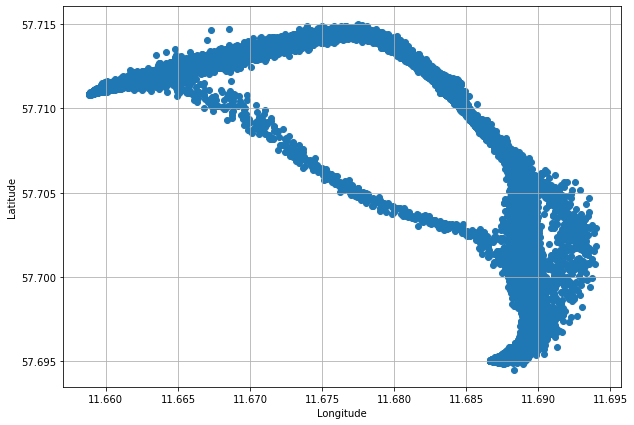

In [27]:
# Create a scatter plot of latitude and longitude to visualize the ferry's path
fig = plt.figure(figsize=(10,7))
plt.scatter(dforig['longitude'], dforig['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

plt.savefig(Output_folder+'/Scatter_dforig_lat_lon_Non-Direct_Direct_paths.png', dpi=500)  

plt.show()

In [28]:
# st=stop

### Data Processing for Route's Classes

In [29]:
if Branch==21:
    df_dest21=df
    df=df_dest21
    df['direction'] = df['Direct_RT'].apply(lambda x: 'Direct' if x ==1 else 'Non-Direct')

    
    
if Branch==52: 
    df_dest52=pd.DataFrame([])
    df_dest5=df

    df_dest51=df_dest5[(df_dest5.latitude<57.710)]
    df_dest52=df_dest51[(df_dest51.longitude>11.685)]
    
    # Create a new binary variable for the direction (Non-Direct or Direct)
    df=df_dest52
    df['direction'] = df_dest52['longitude'].apply(lambda x: 'Non-Direct' if x <11.6905 else 'Direct')
    

    
if Branch==62:  ### Direct, West_Canal, and East_Canal

    df_dest21=pd.DataFrame([])
    df_dest21=df[df.Direct_RT==1]
    df_dest21['direction'] = 'Direct'
    
    # Group the rows by RT_id and check if any group has direction == 'Direct'
    direct_groups = df_dest21.groupby('RT_id')['direction'].transform(lambda x: 'Direct' in x.values)
    # Replace direction values in groups where east_canal_groups is True
    df_dest21.loc[direct_groups, 'direction'] = 'Direct'

    
    df_dest52=pd.DataFrame([])
    df_dest5=df

    df_dest51=df_dest5[(df_dest5.latitude<57.705) & (df_dest5.latitude>57.700)]
    df_dest52=df_dest51[(df_dest51.longitude>11.6875)]
    
    df_dest52['direction'] = df_dest52['longitude'].apply(lambda x: 'West_Canal' if x <11.6905 else 'East_Canal')
    
    # Group the rows by RT_id and check if any group has direction == 'East_Canal'
    east_canal_groups = df_dest52.groupby('RT_id')['direction'].transform(lambda x: 'East_Canal' in x.values)

    # Replace direction values in groups where east_canal_groups is True
    df_dest52.loc[east_canal_groups, 'direction'] = 'East_Canal'

    
    df=pd.concat([df_dest21, df_dest52], axis=0)
        
df.shape

(4693, 84)

In [30]:
df.RT_id.unique()
df.Direct_RT.unique()
df.Gr_Ock_fg.unique()
df.Direct_RT.value_counts()
df.Gr_Ock_fg.value_counts()
df.RT_id.unique()
pd.Series(df.RT_id.unique()).sort_values().values   

array([   0,    1,    2, ..., 1751, 1752, 1753], dtype=int64)

In [31]:
df.direction.unique()
print(df['direction'].value_counts().sum())
df['direction'].value_counts()

4693


direction
West_Canal    3502
Direct         912
East_Canal     279
Name: count, dtype: int64

In [32]:
# group the "df" DataFrame by "RT_id" and get the most frequent value of "direction" for each group
directions = df.groupby('RT_id')['direction'].agg(lambda x: x.value_counts().index[0]).reset_index()

# merge the "directions" DataFrame with the "dforig" DataFrame based on the "RT_id" column
df_new = pd.merge(dforig, directions, on='RT_id', how='left')

# fill NaN values in the "direction" column with a default value (e.g. "Unknown")
df_new['direction'] = df_new['direction'].fillna('Unknown')


df_new.shape

(39193, 84)

In [33]:
df=df_new
df.index=dforig.index
df.direction.unique()
print(df['direction'].value_counts().sum())
df['direction'].value_counts()

39193


direction
West_Canal    35406
East_Canal     2832
Direct          912
Unknown          43
Name: count, dtype: int64

In [34]:
df['direction'].replace('Unknown', 'West_Canal', inplace=True)
print(df['direction'].value_counts().sum())
df['direction'].value_counts()

39193


direction
West_Canal    35449
East_Canal     2832
Direct          912
Name: count, dtype: int64

In [35]:
dforig1=df
dforig2=df
dforig3=df

In [36]:
df = df[['latitude', 'longitude', 'speedOverGround', 'courseOverGroundTrue',
              'distanceFromDock', 'distanceToNextDock', 'distanceToPreviousDock', 
              'accumDistLeg', 'accumFuelLeg', 'accumTimeLeg', 'EngineFuelRate',
              'windSpeedOverGround', 'windDirectionTrue',  'windSpeed','windDirection', 
              'waveheight', 'wavedirect','currentSpeed', 'currentDirection',
              'windSpeed_sg', 'windDirection_sg', 'Temp_2m', 'Temp_surf',
       'Snow_depth', 'Snow_fall', 'Press_surf', 'Precip',
         'iceCover', 'swellHeight', 'secondarySwellHeight','waterTemperature',
         'direction']]


df['pathSelection']=df.direction

In [37]:
df.shape

(39193, 33)

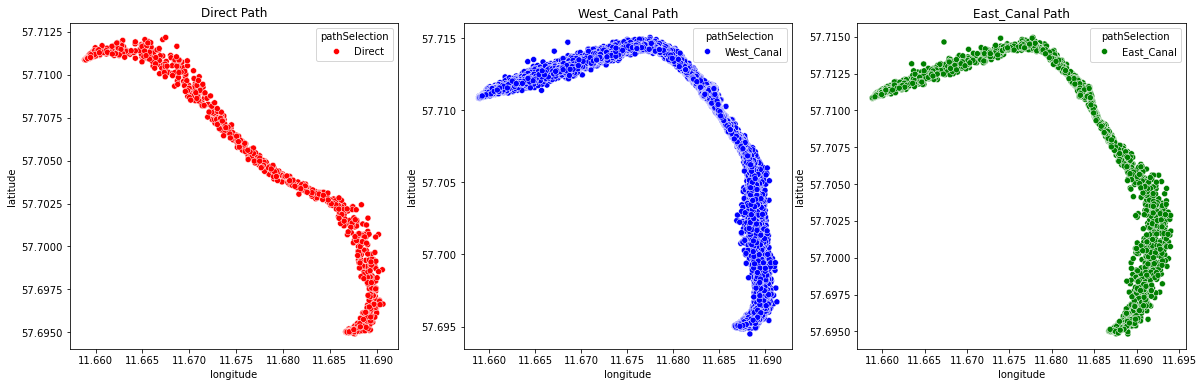

In [38]:
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='pathSelection', data=df[df['pathSelection']=='Direct'], ax=axes[0],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='pathSelection', data=df[df['pathSelection']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='pathSelection', data=df[df['pathSelection']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
for ax in axes:
    ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('Direct Path')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/ScatterPlot_Non-Direct_Direct_paths_features.png', dpi=500)  

plt.show()

In [39]:
# dforig[(dforig.RT_id==1308) & (dforig.Direct_RT==0)].longitude
df.direction.unique()

array(['West_Canal', 'East_Canal', 'Direct'], dtype=object)

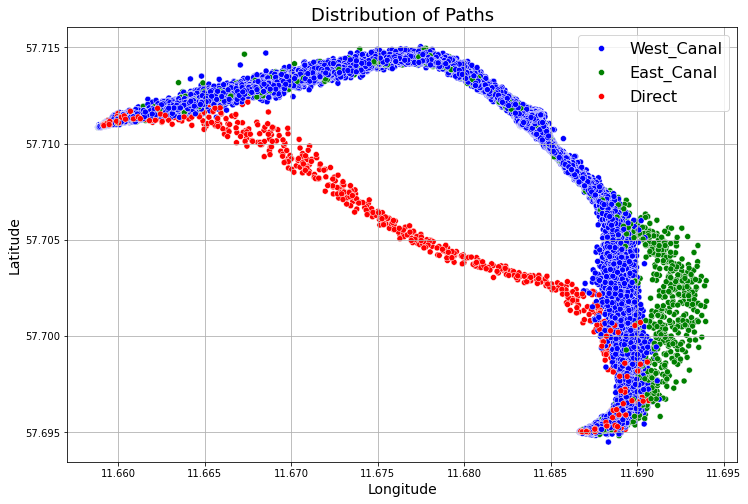

In [40]:
import seaborn as sns
import matplotlib.ticker as ticker

# Visualize the distribution of latitude and longitude for all path classes in a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Use the 'hue' parameter to specify the path selection class
sns.scatterplot(x='longitude', y='latitude', hue='pathSelection', 
                data=df, legend='full', palette=[ 'blue', 'green', 'red'])

# Set number format for axis ticks
ax.ticklabel_format(useOffset=False, style='plain')

# Set title
ax.set_title('Distribution of Paths', fontsize=18)

# Set x-axis format
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Set legend outside the plot with increased font size
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.legend(fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.grid()

plt.savefig(Output_folder+'/ScatterPlot_Colorful_paths.png', dpi=500)  

plt.show()

In [41]:
df.direction.unique()

array(['West_Canal', 'East_Canal', 'Direct'], dtype=object)

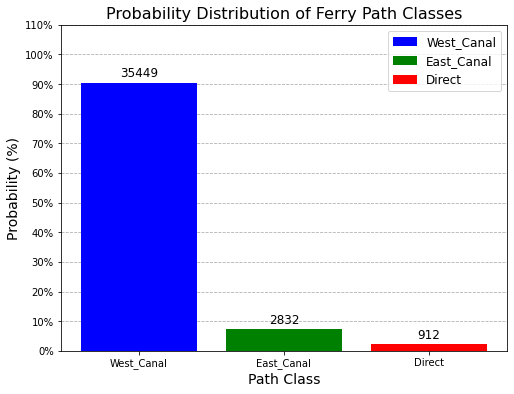

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the probability distribution of each path class
prob_dist = df['direction'].value_counts(normalize=True)
counts = df['direction'].value_counts()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Path Class', fontsize=14)
ax.set_ylabel('Probability (%)', fontsize=14)

# Set the colors and labels for each path class
colors = [ 'blue', 'green', 'red']
labels = ['West_Canal', 'East_Canal', 'Direct']

# Plot the probability distribution for each path class
for i in range(len(labels)):
    ax.bar(labels[i], prob_dist[labels[i]], color=colors[i], label=labels[i], zorder=3)
    ax.text(labels[i], prob_dist[labels[i]]+0.02, str(counts[labels[i]]), ha='center', fontsize=12)

# Set the y-axis labels as percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


# Set the y-axis labels as percentages
ax.yaxis.set_ticks(np.arange(0, max(prob_dist.values)*1+.2, 0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

# Set the title and legend
ax.set_title('Probability Distribution of Ferry Path Classes', fontsize=16)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', zorder=0)

plt.savefig(Output_folder+'/Hist_Point_ferry_paths.png', dpi=500)  

plt.show()


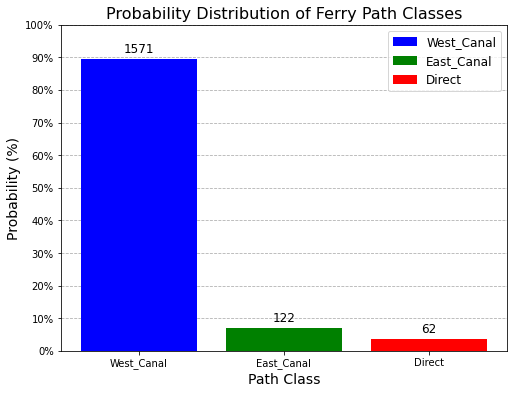

In [43]:
import numpy as np
import matplotlib.pyplot as plt

dforig1['direction']=df.direction
df['RT_id']=dforig1.RT_id

# train_df.groupby(['RT_id']).mean()
rt_class=[]
rt_class=dforig3.groupby('RT_id')['direction'].first()
# rt_class = dforig3.groupby('RT_id')['direction'].apply(lambda x: x.mode()[0])

# Calculate the probability distribution of each path class
prob_dist = rt_class.value_counts(normalize=True)
counts = rt_class.value_counts()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Path Class', fontsize=14)
ax.set_ylabel('Probability (%)', fontsize=14)


# Set the colors and labels for each path class
colors = [ 'blue', 'green', 'red']
labels = ['West_Canal', 'East_Canal', 'Direct']

# Plot the probability distribution for each path class
for i in range(len(labels)):
    ax.bar(labels[i], prob_dist[labels[i]], color=colors[i], label=labels[i], zorder=3)
    ax.text(labels[i], prob_dist[labels[i]]+0.02, str(counts[labels[i]]), ha='center', fontsize=12)

# Set the y-axis labels as percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


# Set the y-axis labels as percentages
ax.yaxis.set_ticks(np.arange(0, max(prob_dist.values)*1+.2, 0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

# Set the title and legend
ax.set_title('Probability Distribution of Ferry Path Classes', fontsize=16)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', zorder=0)

plt.savefig(Output_folder+'/Hist_Path_ferry_paths.png', dpi=500)  

plt.show()


### Distance to the nearest point 
To get a distance matrix for between the routes

In [44]:
# dforig.columns
dforig=dforig1
dforig.direction.unique()
print(dforig.direction.value_counts())
print(dforig.shape)

direction
West_Canal    35449
East_Canal     2832
Direct          912
Name: count, dtype: int64
(39193, 84)


In [45]:
dforig[dforig.Gr_Ock_fg==1].direction.value_counts()

direction
West_Canal    17669
East_Canal     2371
Direct          396
Name: count, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split

dforig2=dforig3; gr_ock_fg=2

# Split data into training and testing sets
train_df, test_df= train_test_split(dforig2, test_size=0.2, shuffle=False)


print(train_df.shape)
print(test_df.shape)



# feats=['latitude', 'longitude', 'hour']

feats=['latitude', 'longitude']

(31354, 84)
(7839, 84)


In [47]:
print(train_df['direction'].value_counts())
print(test_df['direction'].value_counts())

direction
West_Canal    28569
East_Canal     2181
Direct          604
Name: count, dtype: int64
direction
West_Canal    6880
East_Canal     651
Direct         308
Name: count, dtype: int64


#### Example of train_df small to fast the calculation of distance matrix

In [48]:
# rts_list=[3, 5, 1692, 0, 9, 1700, 1, 8, 10, 114, 805, 1697]; rts_list_fg=0

# rts_list=[3, 5, 1692, 0, 9, 1700, 1, 8, 10, 114, 805, 1697, 3, 19, 59, 1700, 200, 788, 829]; rts_list_fg=1

rts_list=list(dforig2.RT_id.unique()); rts_list_fg=2


# train_df=train_df[train_df.RT_id.isin(rts_list)]
train_df=dforig2[dforig2.RT_id.isin(rts_list)]

# train_df.RT_id.unique()

In [49]:
# train_df.groupby(['RT_id']).mean()
df_class_disp=[]
df_class_disp=train_df.groupby('RT_id')['direction'].first()
df_class_disp = df_class_disp.reindex(rts_list)
df_class_disp

RT_id
248     West_Canal
0       West_Canal
1       West_Canal
249     East_Canal
2       West_Canal
           ...    
1751        Direct
1717        Direct
1752        Direct
1753        Direct
1718        Direct
Name: direction, Length: 1755, dtype: object

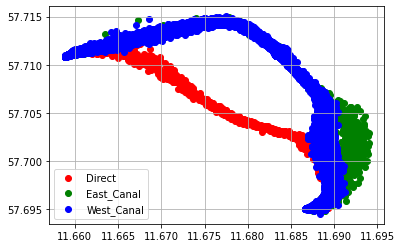

In [50]:
# filter dataframe to include only rows with RT_id values in rts_list
path_plt = train_df[train_df.RT_id.isin(rts_list)]
# path_plt = train_df[train_df.RT_id.isin([3, 9, 1692, 1697, 1700])]

# plot the data
colors = {'Direct': 'red', 'West_Canal': 'blue', 'East_Canal': 'green'}
fig, ax = plt.subplots()
for direction, group in path_plt.groupby('direction'):
    ax.scatter(group['longitude'], group['latitude'], c=colors[direction], label=direction)
    ax.grid()
ax.legend()


plt.savefig(Output_folder+'/scatterplot_GrOck_'+str(gr_ock_fg)+'_3paths_case_'+str(rts_list_fg)+'.png', dpi=500)  

plt.show()

In [51]:
###To find the 'RT_id's that have more than one unique value for the 'direction' column
counts = train_df.groupby('RT_id')['direction'].nunique()
multiple_classes = counts[counts > 1].index.tolist()
print(multiple_classes) ###So there is no path that has more than 1 class

counts = dforig3.groupby('RT_id')['direction'].nunique()
multiple_classes = counts[counts > 1].index.tolist()
print(multiple_classes) ###For the entire data, there is no path that has more than 1 class

[]
[]


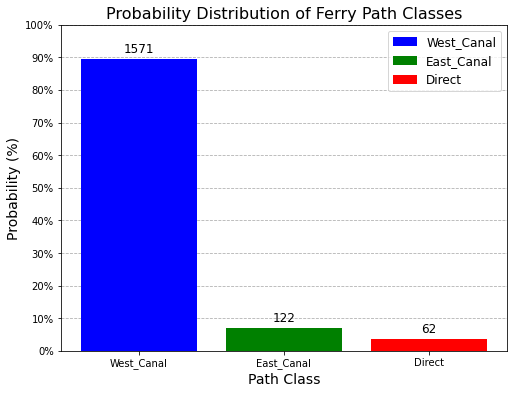

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# train_df.groupby(['RT_id']).mean()
rt_class=[]
# rt_class=train_df.groupby('RT_id')['direction'].first()
rt_class = train_df.groupby('RT_id')['direction'].apply(lambda x: x.mode()[0])
# rt_class = rt_class.reindex(rts_list)
# Calculate the probability distribution of each path class
prob_dist = rt_class.value_counts(normalize=True)
counts = rt_class.value_counts()

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Path Class', fontsize=14)
ax.set_ylabel('Probability (%)', fontsize=14)


# Set the colors and labels for each path class
colors = [ 'blue', 'green', 'red']
labels = ['West_Canal', 'East_Canal', 'Direct']

# Plot the probability distribution for each path class
for i in range(len(labels)):
    ax.bar(labels[i], prob_dist[labels[i]], color=colors[i], label=labels[i], zorder=3)
    ax.text(labels[i], prob_dist[labels[i]]+0.02, str(counts[labels[i]]), ha='center', fontsize=12)

# Set the y-axis labels as percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


# Set the y-axis labels as percentages
ax.yaxis.set_ticks(np.arange(0, max(prob_dist.values)*1+.2, 0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

# Set the title and legend
ax.set_title('Probability Distribution of Ferry Path Classes', fontsize=16)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', zorder=0)

plt.savefig(Output_folder+'/Barplot_hists_3ferry_paths.png', dpi=500)  

plt.show()


In [53]:
train_df.shape

(39193, 84)

In [54]:
train_df[train_df.direction=='East_Canal']
train_df.groupby('RT_id')['direction'].apply(lambda x: x.mode()[0])

RT_id
0       West_Canal
1       West_Canal
2       West_Canal
3       West_Canal
4       West_Canal
           ...    
1750        Direct
1751        Direct
1752        Direct
1753        Direct
1754    West_Canal
Name: direction, Length: 1755, dtype: object

In [55]:
paths = []

# rts_ex=[3, 5, 1692]
rts_ex=[3, 5, 1692, 0, 9, 1700]
rts_ex=rts_list
for pth in rts_ex:
    df_latlon=train_df[train_df.RT_id.isin([pth])]
    path = list(zip(df_latlon['latitude'], df_latlon['longitude']))
    paths.append(path)

len(paths)

1755

#### Computing the distance matrix 

In [56]:
from scipy.spatial import KDTree
import numpy as np

# define a list of paths, each represented as a list of latitude and longitude coordinates
paths=paths

# convert the paths to numpy arrays
path_arrays = [np.array(path) for path in paths]

# compute the distance matrix between paths using KDTree
distances = np.zeros((len(paths), len(paths)))
for i, path1 in enumerate(paths):
    for j, path2 in enumerate(paths):
        if i != j:
            tree = KDTree(np.array(path2))
            dist, idx = tree.query(np.array(path1), k=1)
            distances[i,j] = dist.sum()


# print the distance matrix
distances.shape

(1755, 1755)

In [57]:
## Convert the distances_train array to a DataFrame
df_distance= pd.DataFrame(distances, index=df_class_disp, columns=df_class_disp)

# Rename the index and column names
df_distance.index.name = ''
df_distance.columns.name = ''

# Print the DataFrame
df_distance.round(4)


,West_Canal,West_Canal,West_Canal,East_Canal,West_Canal,West_Canal,West_Canal,West_Canal,West_Canal,West_Canal,...,Direct,Direct,Direct,Direct,Direct,Direct,Direct,Direct,Direct,Direct
,,,,,,,,,,,,,,,,,,,,,
West_Canal,0.0000,0.0114,0.0111,0.0166,0.0120,0.0121,0.0179,0.0130,0.0162,0.0140,...,0.1253,0.1192,0.1216,0.1252,0.1292,0.1132,0.1200,0.1250,0.1177,0.1262
West_Canal,0.0097,0.0000,0.0097,0.0144,0.0110,0.0122,0.0187,0.0096,0.0184,0.0129,...,0.1255,0.1199,0.1213,0.1244,0.1265,0.1135,0.1192,0.1240,0.1201,0.1243
West_Canal,0.0087,0.0096,0.0000,0.0152,0.0108,0.0118,0.0196,0.0103,0.0184,0.0129,...,0.1181,0.1115,0.1156,0.1190,0.1218,0.1086,0.1144,0.1179,0.1147,0.1168
East_Canal,0.0156,0.0150,0.0150,0.0000,0.0204,0.0140,0.0192,0.0205,0.0183,0.0168,...,0.1226,0.1203,0.1215,0.1248,0.1284,0.1112,0.1208,0.1255,0.1172,0.1253
West_Canal,0.0098,0.0097,0.0109,0.0199,0.0000,0.0150,0.0161,0.0046,0.0182,0.0143,...,0.1213,0.1157,0.1190,0.1217,0.1242,0.1094,0.1164,0.1222,0.1175,0.1206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Direct,0.0500,0.0495,0.0513,0.0558,0.0501,0.0507,0.0481,0.0496,0.0509,0.0502,...,0.0214,0.0157,0.0207,0.0217,0.0243,0.0000,0.0174,0.0217,0.0188,0.0220
Direct,0.0401,0.0394,0.0410,0.0469,0.0404,0.0427,0.0435,0.0395,0.0439,0.0417,...,0.0137,0.0078,0.0135,0.0162,0.0127,0.0112,0.0000,0.0107,0.0132,0.0113
Direct,0.0407,0.0399,0.0414,0.0461,0.0430,0.0420,0.0444,0.0420,0.0445,0.0405,...,0.0157,0.0096,0.0098,0.0116,0.0117,0.0140,0.0093,0.0000,0.0112,0.0073


### K-Mean with distance matrix

In [58]:
from sklearn.cluster import KMeans

# Create a dictionary to map cluster labels to path class labels

if rts_list_fg==0:
    cluster_label_map = {
        0: 'East_Canal',
        1: 'Direct',
        2: 'West_Canal'
    }
    
if rts_list_fg==2:
    cluster_label_map = {
        0: 'West_Canal',
        1: 'Direct',
        2: 'East_Canal'
    }
if gr_ock_fg==2:
    cluster_label_map = {
        0: 'East_Canal',
        1: 'Direct',
        2: 'West_Canal'
    }



# Cluster the path classes in train_df based on their distances
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(distances)

clusters_train= kmeans.predict(distances)
clusters_train

# Apply the mapping to the cluster labels
path_class_labels = [cluster_label_map[label] for label in clusters_train]


# path_class_labels


In [59]:
y_pred=np.array(path_class_labels)
y_test=df_class_disp.values
print({class_name: count for class_name, count in zip(*np.unique(y_test, return_counts=True))})
print({class_name: count for class_name, count in zip(*np.unique(y_pred, return_counts=True))})

{'Direct': 62, 'East_Canal': 122, 'West_Canal': 1571}
{'Direct': 62, 'East_Canal': 1572, 'West_Canal': 121}


In [60]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
# print(f'Confusion matrix:\n{conf_mat}')

df_conf_mat = pd.DataFrame(conf_mat, index=['Direct', 'East_Canal', 'West_Canal'], 
                           columns=['Direct', 'East_Canal', 'West_Canal'])
df_conf_mat

,Direct,East_Canal,West_Canal
Direct,62,0,0
East_Canal,0,11,111
West_Canal,0,1561,10


In [61]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Direct       1.00      1.00      1.00        62
  East_Canal       0.01      0.09      0.01       122
  West_Canal       0.08      0.01      0.01      1571

    accuracy                           0.05      1755
   macro avg       0.36      0.37      0.34      1755
weighted avg       0.11      0.05      0.05      1755



In [62]:
report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame.from_dict(report).transpose().round(3)
df_report

,precision,recall,f1-score,support
Direct,1.000,1.000,1.000,62.000
East_Canal,0.007,0.090,0.013,122.000
West_Canal,0.083,0.006,0.012,1571.000
accuracy,0.047,0.047,0.047,0.047
macro avg,0.363,0.366,0.342,1755.000
weighted avg,0.110,0.047,0.047,1755.000


In [63]:
train_df.shape

(39193, 84)

In [64]:
np.unique(labels)

array(['Direct', 'East_Canal', 'West_Canal'], dtype='<U10')

In [65]:
y_pred
y_test
# Find the indices of mismatched entries
mismatch_indices = np.where(y_pred != y_test)[0]

# Print the indices of mismatched entries
print(mismatch_indices.shape)
print("Indices of mismatched entries:")
print(mismatch_indices)

(1672,)
Indices of mismatched entries:
[   0    1    2 ... 1742 1743 1744]


In [66]:
# distances[mismatch_indices.tolist(),mismatch_indices.tolist()]

In [67]:
misclus_rts=df_class_disp.iloc[mismatch_indices.tolist()]
misclus_rts

RT_id
248     West_Canal
0       West_Canal
1       West_Canal
249     East_Canal
2       West_Canal
           ...    
1067    West_Canal
1068    West_Canal
1069    West_Canal
1070    West_Canal
1071    West_Canal
Name: direction, Length: 1672, dtype: object

In [68]:
misclus_rts.index

Index([ 248,    0,    1,  249,    2,  250,  251,    3,  252,    4,
       ...
       1690, 1064, 1691, 1065, 1066, 1067, 1068, 1069, 1070, 1071],
      dtype='int64', name='RT_id', length=1672)

In [69]:
# st=stop

### Plot clustering results from K-means

In [70]:
dforig.shape

(39193, 84)

In [71]:
from collections import Counter
print(len(rts_list))
print(y_test.shape)
print(y_pred.shape)
print(Counter(y_test))
print(Counter(y_pred))

1755
(1755,)
(1755,)
Counter({'West_Canal': 1571, 'East_Canal': 122, 'Direct': 62})
Counter({'East_Canal': 1572, 'West_Canal': 121, 'Direct': 62})


In [72]:
# dforig2[['RT_id', 'direction', 'latitude', 'longitude']]

In [73]:
# Create a new DataFrame dforig2_result with the same structure as dforig2
dforig2_result = dforig2[['RT_id', 'latitude', 'longitude']].copy()

# Assign the cluster assignments to the 'direction' column of dforig2_result
for i, rt_id in enumerate(rts_list):
    idx = dforig2['RT_id'] == rt_id
    dforig2_result.loc[idx, 'direction'] = y_pred[i]

# Convert the 'direction' column to integer type
dforig2_result['direction'] = dforig2_result['direction']

# Verify the result
dforig2_result

,RT_id,latitude,longitude,direction
date,,,,
2020-01-16 13:10:00,248,57.711047,11.659483,East_Canal
2020-01-16 13:11:00,248,57.711401,11.660977,East_Canal
2020-01-16 13:12:00,248,57.712142,11.664302,East_Canal
2020-01-16 13:13:00,248,57.713221,11.668567,East_Canal
2020-01-16 13:14:00,248,57.714124,11.672979,East_Canal
...,...,...,...,...
2021-03-12 14:47:00,1718,57.709019,11.669584,Direct
2021-03-12 14:48:00,1718,57.709871,11.667433,Direct
2021-03-12 14:49:00,1718,57.710742,11.664951,Direct


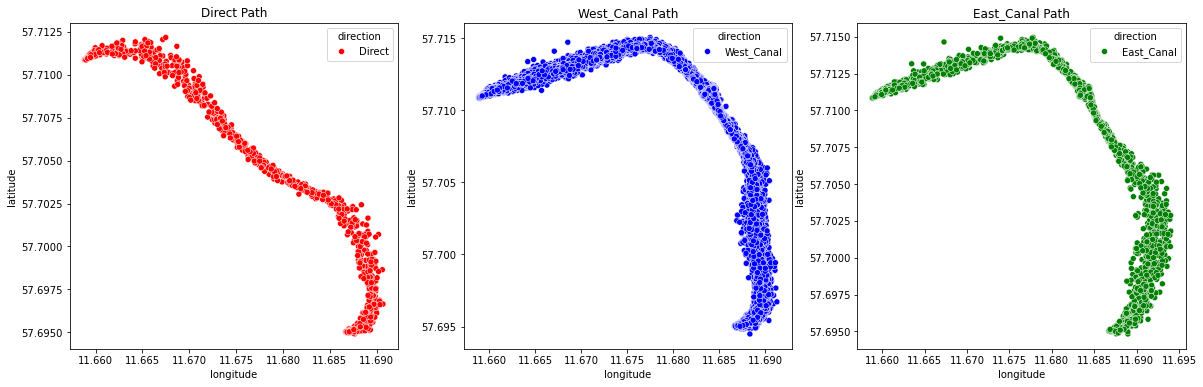

In [74]:
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='Direct'], ax=axes[0],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
for ax in axes:
    ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('Direct Path')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/ScatterPlot_actual_kmean_restult_paths.png', dpi=500)  

plt.show()

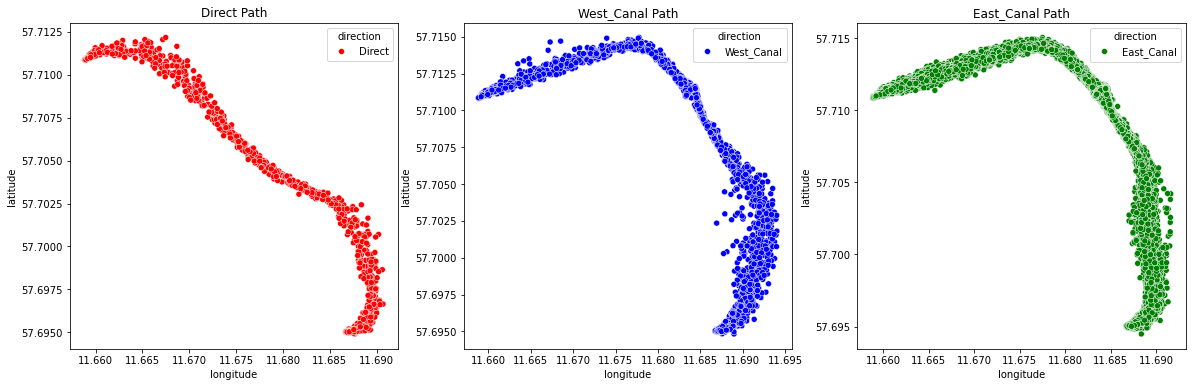

In [75]:
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result[dforig2_result['direction']=='Direct'], ax=axes[0],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result[dforig2_result['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result[dforig2_result['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
for ax in axes:
    ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('Direct Path')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/ScatterPlot_pred_Kmean_restult_paths.png', dpi=500)  

plt.show()

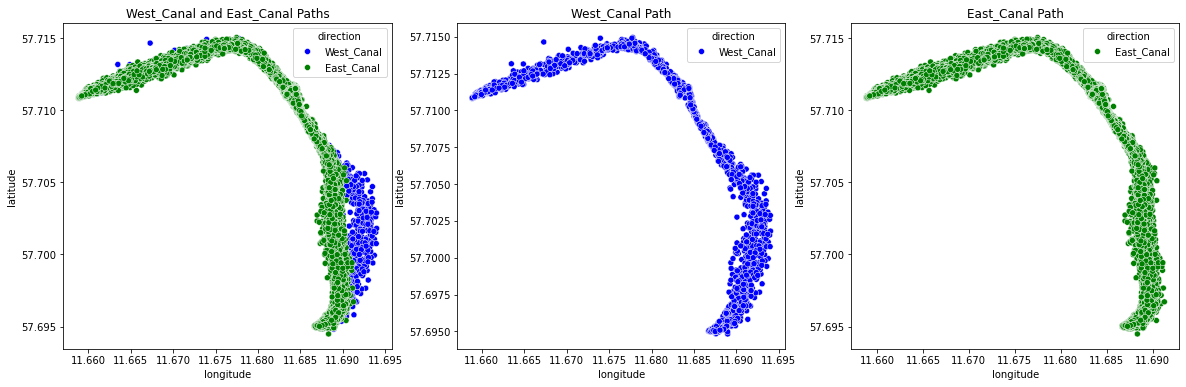

In [76]:
misclusters=dforig2_result[dforig2_result.RT_id.isin(misclus_rts.index.tolist())]
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters[misclusters['direction']=='West_Canal'], ax=axes[0],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters[misclusters['direction']=='East_Canal'], ax=axes[0],  palette=['green'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters[misclusters['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters[misclusters['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
# for ax in axes:
#     ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('West_Canal and East_Canal Paths')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/Scatter_3Plots_pred_miscluster_kmean_restult_paths.png', dpi=500)  

plt.show()

####  Plot PDF for Mis-Clustered Routes form K-means

In [77]:
df_misclus=dforig2[dforig2.RT_id.isin(misclus_rts.index.tolist())]
df_corct_clus=dforig2[~dforig2.RT_id.isin(misclus_rts.index.tolist())]

print(df_misclus.shape)
print(df_misclus.direction.unique())
df_misclus[['RT_id', 'latitude', 'longitude', 'direction']]

(37774, 84)
['West_Canal' 'East_Canal']


,RT_id,latitude,longitude,direction
date,,,,
2020-01-16 13:10:00,248,57.711047,11.659483,West_Canal
2020-01-16 13:11:00,248,57.711401,11.660977,West_Canal
2020-01-16 13:12:00,248,57.712142,11.664302,West_Canal
2020-01-16 13:13:00,248,57.713221,11.668567,West_Canal
2020-01-16 13:14:00,248,57.714124,11.672979,West_Canal
...,...,...,...,...
2021-01-17 18:02:00,1071,57.712687,11.667191,West_Canal
2021-01-17 18:03:00,1071,57.711843,11.662908,West_Canal
2021-01-17 18:04:00,1071,57.711066,11.659614,West_Canal


             latitude  longitude
direction                       
East_Canal  57.708470   11.68032
West_Canal  57.708359   11.68067
            latitude  longitude
direction                      
East_Canal  0.005628   0.010499
West_Canal  0.005774   0.009222


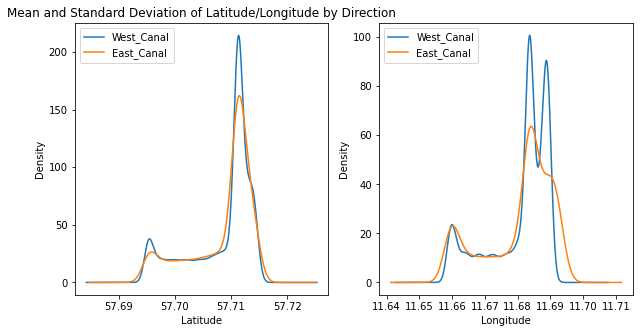

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# group the data by the 'direction' column and calculate the mean and standard deviation for the 'latitude' and 'longitude' columns
df_means = df_misclus.groupby('direction').agg({'latitude': 'mean', 'longitude': 'mean'})
df_stds = df_misclus.groupby('direction').agg({'latitude': 'std', 'longitude': 'std'})

print(df_means)
print(df_stds)

# create subplots for the means and standard deviations
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot the means and standard deviations
# df_means.plot(kind='bar', ax=ax1, yerr=df_stds, capsize=3)
ax1.set_ylabel('Mean Latitude/Longitude')
ax1.set_title('Mean and Standard Deviation of Latitude/Longitude by Direction')

# plot the probability density function (PDF) for each latitude and longitude column
for col, ax in zip(['latitude', 'longitude'], [ax1, ax2]):
    for direction in df_misclus['direction'].unique():
        data = df_misclus.loc[df_misclus['direction'] == direction, col]
        data.plot(kind='density', ax=ax, label=direction)
    ax.legend()
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Density')

fig.savefig('Plot_misclustering_pdfs.png', dpi=500)
fig.savefig(Output_folder+'/Plot_misclustering_kmean_pdfs.png', dpi=500)  
plt.show()

             latitude  longitude
direction                       
Direct      57.704954  11.675912
East_Canal  57.708455  11.680675
West_Canal  57.708307  11.680020
            latitude  longitude
direction                      
Direct      0.005637   0.010989
East_Canal  0.005712   0.009630
West_Canal  0.005918   0.009983


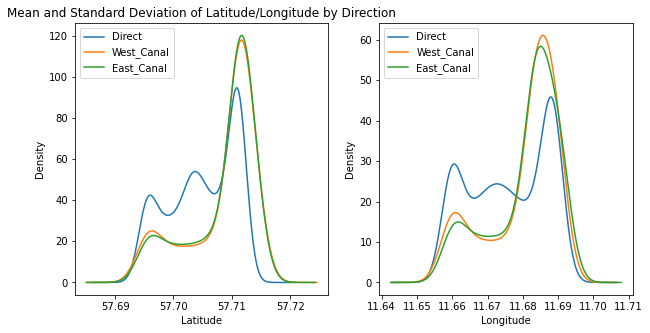

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# group the data by the 'direction' column and calculate the mean and standard deviation for the 'latitude' and 'longitude' columns
df_corrct_means = df_corct_clus.groupby('direction').agg({'latitude': 'mean', 'longitude': 'mean'})
df_corrct_std = df_corct_clus.groupby('direction').agg({'latitude': 'std', 'longitude': 'std'})

print(df_corrct_means)
print(df_corrct_std)

# create subplots for the means and standard deviations
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot the means and standard deviations
# df_corrct_means.plot(kind='bar', ax=ax1, yerr=df_corrct_std, capsize=3)
ax1.set_ylabel('Mean Latitude/Longitude')
ax1.set_title('Mean and Standard Deviation of Latitude/Longitude by Direction')

# plot the probability density function (PDF) for each latitude and longitude column
for col, ax in zip(['latitude', 'longitude'], [ax1, ax2]):
    for direction in df_corct_clus['direction'].unique():
        data = df_corct_clus.loc[df_corct_clus['direction'] == direction, col]
        data.plot(kind='density', ax=ax, label=direction)
    ax.legend()
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Density')
    
fig.savefig('Plot_correct_clustering_pdfs.png', dpi=500)
fig.savefig(Output_folder+'/Plot_correct_clustering_kmean_pdfs.png', dpi=500)  
plt.show()

In [80]:
# st=stop

### GMM with distance matrix

In [81]:
from sklearn.mixture import GaussianMixture

# Create a dictionary to map cluster labels to path class labels

if rts_list_fg==0:
    cluster_label_map = {
        0: 'East_Canal',
        1: 'Direct',
        2: 'West_Canal'}
    

if gr_ock_fg==2:
    cluster_label_map = {
        0: 'West_Canal',
        1: 'Direct',
        2: 'East_Canal' }



# Cluster the path classes in train_df based on their distances
# Initialize GMM with 3 clusters
gmm = GaussianMixture(n_components=3)

# Fit the model on the data
gmm.fit(distances)

gmm_labels= gmm.predict(distances)

gmm_labels

# Apply the mapping to the cluster labels
gmm_class_labels = [cluster_label_map[label] for label in gmm_labels]


# gmm_class_labels


In [82]:
y_pred_gmm=np.array(gmm_class_labels)
y_test_gmm=df_class_disp.values
print({class_name: count for class_name, count in zip(*np.unique(y_test_gmm, return_counts=True))})
print({class_name: count for class_name, count in zip(*np.unique(y_pred_gmm, return_counts=True))})

{'Direct': 62, 'East_Canal': 122, 'West_Canal': 1571}
{'Direct': 62, 'East_Canal': 133, 'West_Canal': 1560}


In [83]:
from sklearn.metrics import confusion_matrix
conf_mat_gmm = confusion_matrix(y_test_gmm, y_pred_gmm)
# print(f'Confusion matrix:\n{conf_mat_gmm}')

df_conf_mat_gmm = pd.DataFrame(conf_mat_gmm, index=['Direct', 'East_Canal', 'West_Canal'], 
                           columns=['Direct', 'East_Canal', 'West_Canal'])
df_conf_mat_gmm

,Direct,East_Canal,West_Canal
Direct,62,0,0
East_Canal,0,122,0
West_Canal,0,11,1560


In [84]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print(classification_report(y_test_gmm, y_pred_gmm))


              precision    recall  f1-score   support

      Direct       1.00      1.00      1.00        62
  East_Canal       0.92      1.00      0.96       122
  West_Canal       1.00      0.99      1.00      1571

    accuracy                           0.99      1755
   macro avg       0.97      1.00      0.98      1755
weighted avg       0.99      0.99      0.99      1755



In [85]:
report = classification_report(y_test_gmm, y_pred_gmm, output_dict=True)

df_report = pd.DataFrame.from_dict(report).transpose().round(3)
df_report

,precision,recall,f1-score,support
Direct,1.000,1.000,1.000,62.000
East_Canal,0.917,1.000,0.957,122.000
West_Canal,1.000,0.993,0.996,1571.000
accuracy,0.994,0.994,0.994,0.994
macro avg,0.972,0.998,0.984,1755.000
weighted avg,0.994,0.994,0.994,1755.000


In [86]:
np.unique(labels)

array(['Direct', 'East_Canal', 'West_Canal'], dtype='<U10')

In [87]:
y_pred_gmm
y_test_gmm
# Find the indices of mismatched entries
mismatch_gmm_indices = np.where(y_pred_gmm != y_test_gmm)[0]

# Print the indices of mismatched entries
print(mismatch_gmm_indices.shape)
print("Indices of mismatched entries:")
print(mismatch_gmm_indices)

(11,)
Indices of mismatched entries:
[  75   82  668  670  746  805  815  818 1404 1408 1526]


In [88]:
misclus_gmm_rts=df_class_disp.iloc[mismatch_gmm_indices.tolist()]
misclus_gmm_rts

RT_id
41     West_Canal
45     West_Canal
553    West_Canal
554    West_Canal
589    West_Canal
616    West_Canal
620    West_Canal
622    West_Canal
902    West_Canal
903    West_Canal
960    West_Canal
Name: direction, dtype: object

In [89]:
misclus_gmm_rts.index

Index([41, 45, 553, 554, 589, 616, 620, 622, 902, 903, 960], dtype='int64', name='RT_id')

In [90]:
# st=stop

### Plot clustering results from GMM

In [91]:
dforig.shape

(39193, 84)

In [92]:
from collections import Counter
print(len(rts_list))
print(y_test_gmm.shape)
print(y_pred_gmm.shape)
print(Counter(y_test_gmm))
print(Counter(y_pred_gmm))

1755
(1755,)
(1755,)
Counter({'West_Canal': 1571, 'East_Canal': 122, 'Direct': 62})
Counter({'West_Canal': 1560, 'East_Canal': 133, 'Direct': 62})


In [93]:
# dforig2[['RT_id', 'direction', 'latitude', 'longitude']]

In [94]:
# Create a new DataFrame dforig2_result with the same structure as dforig2
dforig2_result_gmm = dforig2[['RT_id', 'latitude', 'longitude']].copy()

# Assign the cluster assignments to the 'direction' column of dforig2_result
for i, rt_id in enumerate(rts_list):
    idx = dforig2['RT_id'] == rt_id
    dforig2_result_gmm.loc[idx, 'direction'] = y_pred[i]

# Convert the 'direction' column to integer type
dforig2_result_gmm['direction'] = dforig2_result_gmm['direction']

# Verify the result
dforig2_result_gmm

,RT_id,latitude,longitude,direction
date,,,,
2020-01-16 13:10:00,248,57.711047,11.659483,East_Canal
2020-01-16 13:11:00,248,57.711401,11.660977,East_Canal
2020-01-16 13:12:00,248,57.712142,11.664302,East_Canal
2020-01-16 13:13:00,248,57.713221,11.668567,East_Canal
2020-01-16 13:14:00,248,57.714124,11.672979,East_Canal
...,...,...,...,...
2021-03-12 14:47:00,1718,57.709019,11.669584,Direct
2021-03-12 14:48:00,1718,57.709871,11.667433,Direct
2021-03-12 14:49:00,1718,57.710742,11.664951,Direct


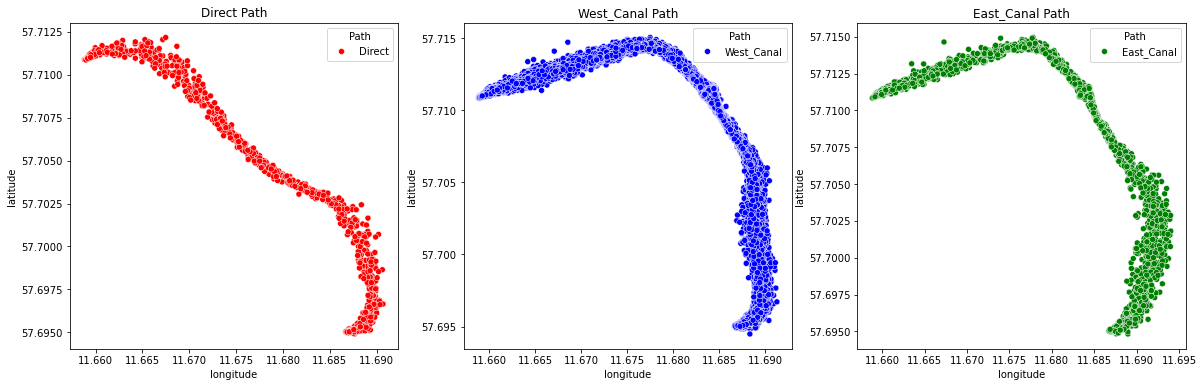

In [95]:
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='Direct'], ax=axes[0],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
for ax in axes:
    ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('Direct Path')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[0].legend(title='Path')
axes[1].legend(title='Path')
axes[2].legend(title='Path')


axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/ScatterPlot_actual_restult_gmm_paths.png', dpi=500)  

plt.show()

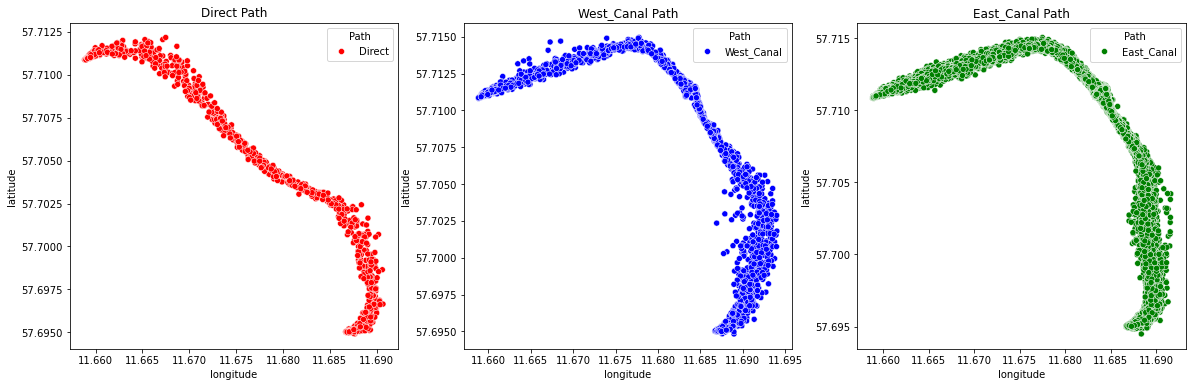

In [96]:
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result_gmm[dforig2_result_gmm['direction']=='Direct'], ax=axes[0],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result_gmm[dforig2_result_gmm['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result_gmm[dforig2_result_gmm['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
for ax in axes:
    ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('Direct Path')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[0].legend(title='Path')
axes[1].legend(title='Path')
axes[2].legend(title='Path')


axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/ScatterPlot_pred_restult_gmm_paths.png', dpi=500)  

plt.show()

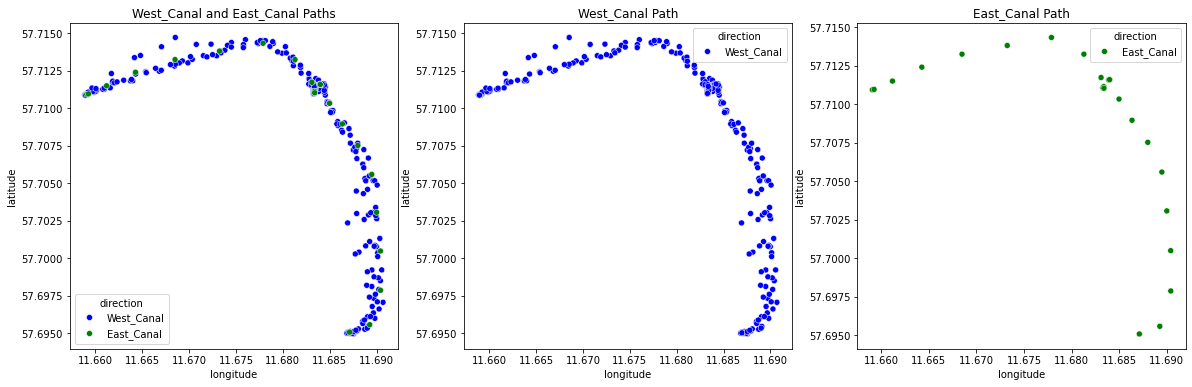

In [97]:
misclusters_gmm=dforig2_result_gmm[dforig2_result_gmm.RT_id.isin(misclus_gmm_rts.index.tolist())]
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='West_Canal'], ax=axes[0],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='East_Canal'], ax=axes[0],  palette=['green'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='East_Canal'], ax=axes[2],  palette=['green'])

# Set number format for axis ticks
# for ax in axes:
#     ax.ticklabel_format(useOffset=False, style='plain')


axes[0].set_title('West_Canal and East_Canal Paths')
axes[1].set_title('West_Canal Path')
axes[2].set_title('East_Canal Path')

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))


plt.savefig(Output_folder+'/Scatter_3Plots_pred_miscluster_restult_gmm_paths.png', dpi=500)  

plt.show()

####  Scatter plots with light correctly clustered trips and dark for misclustered from GMM

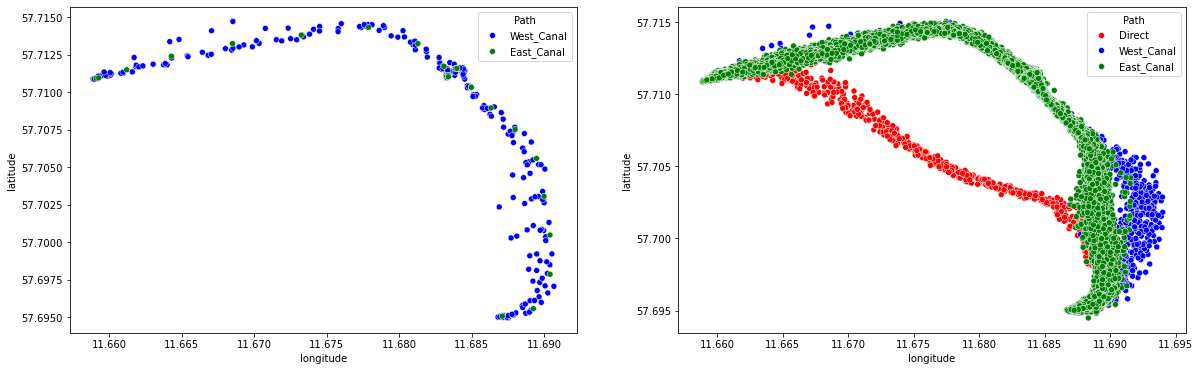

In [98]:
misclusters_gmm=dforig2_result_gmm[dforig2_result_gmm.RT_id.isin(misclus_gmm_rts.index.tolist())]
import seaborn as sns

# Visualize the distribution of latitude and longitude for both paths
import matplotlib.ticker as ticker
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='West_Canal'], ax=axes[0],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=misclusters_gmm[misclusters_gmm['direction']=='East_Canal'], ax=axes[0],  palette=['green'])

sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2[dforig2['direction']=='Direct'], ax=axes[1],  palette=['red'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result_gmm[dforig2_result_gmm['direction']=='West_Canal'], ax=axes[1],  palette=['blue'])
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=dforig2_result_gmm[dforig2_result_gmm['direction']=='East_Canal'], ax=axes[1],  palette=['green'])


# Set legend titles
axes[0].legend(title='Path')
axes[1].legend(title='Path')
axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

plt.savefig(Output_folder+'/Scatter_2Plots_miscluster_Correct_gmm_paths.png', dpi=500)  

plt.show()

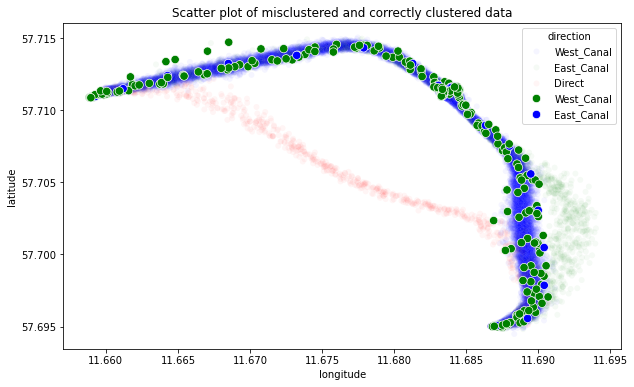

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Assuming misclusters_gmm and dforig2 are your dataframes

# Create a new column in misclusters_gmm to distinguish it from dforig2
misclusters_gmm['cluster'] = 'misclustered'
dforig2['cluster'] = 'correctly clustered'

# Combine the dataframes
combined_data = pd.concat([misclusters_gmm, dforig2], axis=0)

# Visualize the distribution of latitude and longitude for both paths
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Plot misclustered data as regular points
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=combined_data[combined_data['cluster']=='correctly clustered'], ax=axes, alpha=0.04, palette=['blue', 'green', 'red'])

# Plot correctly clustered data as blurry points with lower alpha value
sns.scatterplot(x='longitude', y='latitude', hue='direction', data=combined_data[combined_data['cluster']=='misclustered'], ax=axes, alpha=1, palette=['green', 'blue'], s=70)

misclustered_legend_labels = ['Misclustered_West_Canal', 'Misclustered_East_Canal', 'Misclustered_Direct']

# Get the legend handles and labels
handles, labels = axes.get_legend_handles_labels()

# Update the legend labels for the misclustered data plot
labels[3:] = misclustered_legend_labels

# Set sizes for the scatter plot markers in the legend
for handle in handles[-3:]:
    handle.set_markerfacecolor('none')  # Make the marker face color transparent
    handle.set_markersize(10)  # Set the marker size

# Set x-axis format
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Set plot title
plt.title('Scatter plot of misclustered and correctly clustered data')

plt.savefig(Output_folder+'/Scatter_1Plot_dark_miscluster_ligthCorrect_gmm_paths.png', dpi=500)  

plt.show()


####  Plot PDF for Mis-Clustered Trips from GMM

In [100]:
ec_rt_list=list(dforig2[dforig2.direction=='East_Canal'].RT_id.unique())
len(ec_rt_list)

122

In [101]:
df_gmm_misclus=dforig2[dforig2.RT_id.isin(misclus_gmm_rts.index.tolist())]
df_gmm_corct_clus=dforig2[~dforig2.RT_id.isin(misclus_gmm_rts.index.tolist())]
df_ec_path=dforig2[dforig2.RT_id.isin(ec_rt_list)]
df_gmm_misclus_ec_path=pd.concat([df_gmm_misclus, df_ec_path], axis=0)

print(df_gmm_misclus.shape)
print(df_gmm_misclus.direction.unique())
print(df_ec_path.direction.unique())
print(df_gmm_misclus_ec_path.direction.unique())


df_gmm_misclus[['RT_id', 'latitude', 'longitude', 'direction']]

(294, 85)
['West_Canal']
['East_Canal']
['West_Canal' 'East_Canal']


,RT_id,latitude,longitude,direction
date,,,,
2020-01-22 06:35:00,41,57.695111,11.687206,West_Canal
2020-01-22 06:36:00,41,57.696100,11.689037,West_Canal
2020-01-22 06:37:00,41,57.697058,11.690686,West_Canal
2020-01-22 06:38:00,41,57.695757,11.688489,West_Canal
2020-01-22 06:39:00,41,57.695053,11.686879,West_Canal
...,...,...,...,...
2020-11-15 10:34:00,960,57.712273,11.664293,West_Canal
2020-11-15 10:35:00,960,57.711329,11.660935,West_Canal
2020-11-15 10:36:00,960,57.710853,11.658924,West_Canal


             latitude  longitude
direction                       
East_Canal  57.708469   11.68035
West_Canal  57.708333   11.68005
            latitude  longitude
direction                      
East_Canal  0.005634   0.010427
West_Canal  0.005889   0.009972


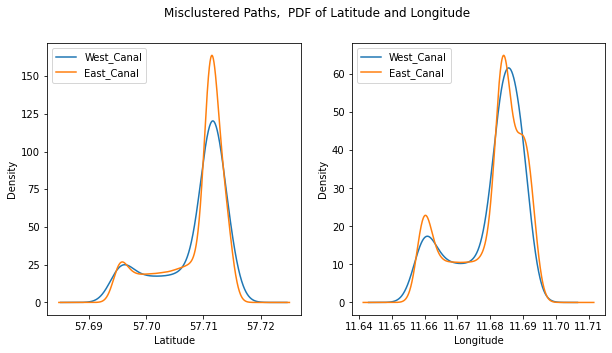

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# group the data by the 'direction' column and calculate the mean and standard deviation for the 'latitude' and 'longitude' columns
# df_gmm_means = df_gmm_misclus.groupby('direction').agg({'latitude': 'mean', 'longitude': 'mean'})
# df_gmm_stds = df_gmm_misclus.groupby('direction').agg({'latitude': 'std', 'longitude': 'std'})

df_gmm_means = df_gmm_misclus_ec_path.groupby('direction').agg({'latitude': 'mean', 'longitude': 'mean'})
df_gmm_stds = df_gmm_misclus_ec_path.groupby('direction').agg({'latitude': 'std', 'longitude': 'std'})


print(df_gmm_means)
print(df_gmm_stds)

# create subplots for the means and standard deviations
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot the means and standard deviations
# df_means.plot(kind='bar', ax=ax1, yerr=df_stds, capsize=3)
ax1.set_ylabel('Mean Latitude/Longitude')

# plot the probability density function (PDF) for each latitude and longitude column
for col, ax in zip(['latitude', 'longitude'], [ax1, ax2]):
    for direction in df_gmm_misclus_ec_path['direction'].unique():
        data = df_gmm_misclus_ec_path.loc[df_gmm_misclus_ec_path['direction'] == direction, col]
        data.plot(kind='density', ax=ax, label=direction)
    ax.legend()
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Density')
    
plt.suptitle('Misclustered Paths,  PDF of Latitude and Longitude')

fig.savefig('Plot_misclustering_pdfs.png', dpi=500)
fig.savefig(Output_folder+'/Plot_misclustering_gmm_pdfs.png', dpi=500)  
plt.show()

             latitude  longitude
direction                       
Direct      57.704954  11.675912
East_Canal  57.708469  11.680350
West_Canal  57.708358  11.680670
            latitude  longitude
direction                      
Direct      0.005637   0.010989
East_Canal  0.005634   0.010427
West_Canal  0.005774   0.009222


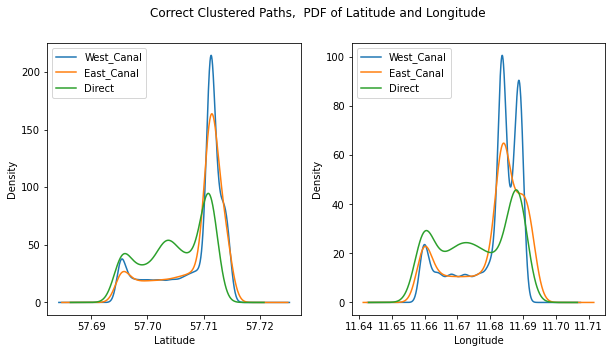

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# group the data by the 'direction' column and calculate the mean and standard deviation for the 'latitude' and 'longitude' columns
df_gmm_corrct_means = df_gmm_corct_clus.groupby('direction').agg({'latitude': 'mean', 'longitude': 'mean'})
df_gmm_corrct_std = df_gmm_corct_clus.groupby('direction').agg({'latitude': 'std', 'longitude': 'std'})

print(df_gmm_corrct_means)
print(df_gmm_corrct_std)

# create subplots for the means and standard deviations
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot the means and standard deviations
# df_corrct_means.plot(kind='bar', ax=ax1, yerr=df_corrct_std, capsize=3)
ax1.set_ylabel('Mean Latitude/Longitude')

# plot the probability density function (PDF) for each latitude and longitude column
for col, ax in zip(['latitude', 'longitude'], [ax1, ax2]):
    for direction in df_gmm_corct_clus['direction'].unique():
        data = df_gmm_corct_clus.loc[df_gmm_corct_clus['direction'] == direction, col]
        data.plot(kind='density', ax=ax, label=direction)
    ax.legend()
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Density')
    
plt.suptitle('Correct Clustered Paths,  PDF of Latitude and Longitude')

fig.savefig('Plot_correct_clustering_gmm_pdfs.png', dpi=500)
fig.savefig(Output_folder+'/Plot_correct_clustering_gmm_pdfs.png', dpi=500)  
plt.show()

In [104]:
# st=stop

#### Hierachical clustering wiht distance matrix

[1 2 3]


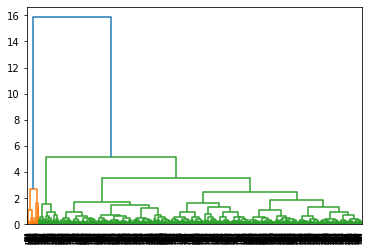

In [105]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# Define the linkage method
# Z = linkage(distances, method='complete')
Z = linkage(distances, method='ward')


# Plot the dendrogram to visualize the clustering
dendrogram(Z)

## Divide the paths into three clusters
## Adjust this threshold based on the dendrogram plot

if rts_list_fg==0:
    max_dist =0.04 
    
if (rts_list_fg==2) & (gr_ock_fg==0):
    max_dist = 1.6  # 
    
if (rts_list_fg==2) & (gr_ock_fg==1):
    max_dist = 2.8 

if (rts_list_fg==2) & (gr_ock_fg==2):
    max_dist = 4.7
    
clusters = fcluster(Z, t=max_dist, criterion='distance')

# print(clusters)
print(np.unique(clusters))
# Save the dendrogram plot to a file
plt.savefig(Output_folder+'/Dendrogram_'+str(gr_ock_fg)+'_3paths.png', dpi=500)  
plt.show()

In [113]:
print(max_dist)


4.7


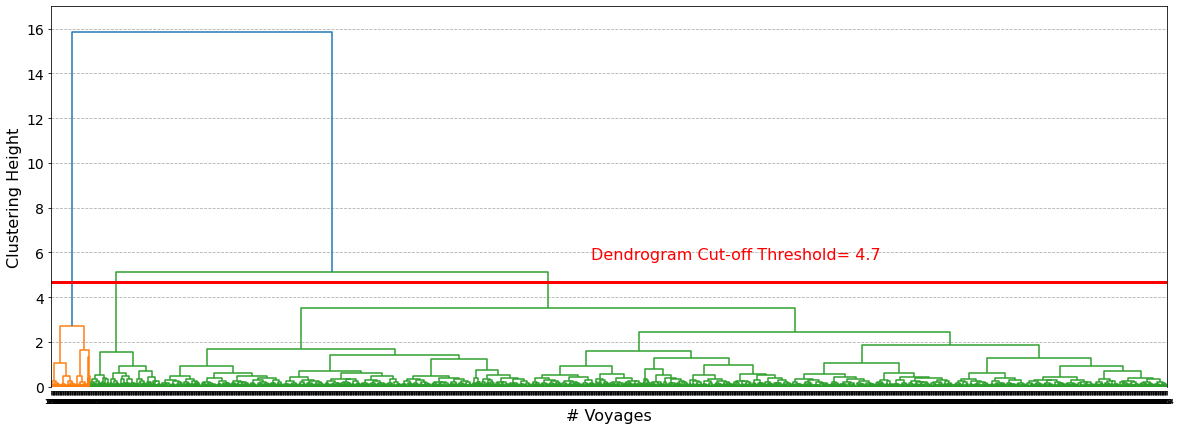

In [122]:
import matplotlib.pyplot as plt

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(20, 7))
dendrogram(Z, ax=ax)

# Set the y-axis limits
ax.set_ylim([0, 17])
ax.set_xlabel('# Voyages', fontsize=16)
ax.set_ylabel('Clustering Height', fontsize=16)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=14)

# Plot a horizontal line at y=7 with color red
plt.axhline(y=max_dist, color='red', linewidth=3)  # Specify the linewidth
plt.text(8500, max_dist + 1, 'Dendrogram Cut-off Threshold= '+str(max_dist), color='red', fontsize=16)

ax.spines['bottom'].set_position(('outward', 4))  # Adjust this value to move the ticks closer

ax.grid(axis='y', linestyle='--', zorder=0)

# Save the dendrogram plot to a file
plt.savefig(Output_folder+'/Fig_Buro_3paths_Hierarch.png', dpi=300)
plt.show()


In [123]:
Z

array([[4.88000000e+02, 4.89000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.96000000e+02, 4.97000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.94000000e+02, 4.95000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [3.50200000e+03, 3.50400000e+03, 3.51111863e+00, 1.58200000e+03],
       [3.49900000e+03, 3.50600000e+03, 5.12203412e+00, 1.69300000e+03],
       [3.50500000e+03, 3.50700000e+03, 1.58502525e+01, 1.75500000e+03]])

In [124]:
cluster_map2 = {
        1: 'Direct',
        2: 'East_Canal',
        3: 'West_Canal'
    }

path_class_labels = [cluster_map2[label] for label in clusters]

y_pred=np.array(path_class_labels)
y_test=df_class_disp.values
{class_name: count for class_name, count in zip(*np.unique(y_test, return_counts=True))}
{class_name: count for class_name, count in zip(*np.unique(y_pred, return_counts=True))}

{'Direct': 62, 'East_Canal': 111, 'West_Canal': 1582}

In [125]:

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{conf_mat}')

Confusion matrix:
[[  62    0    0]
 [   0  105   17]
 [   0    6 1565]]


In [126]:
report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame.from_dict(report).transpose().round(3)
df_report

,precision,recall,f1-score,support
Direct,1.000,1.000,1.000,62.000
East_Canal,0.946,0.861,0.901,122.000
West_Canal,0.989,0.996,0.993,1571.000
accuracy,0.987,0.987,0.987,0.987
macro avg,0.978,0.952,0.965,1755.000
weighted avg,0.987,0.987,0.987,1755.000
